**Importing Necessary Libraries**

In [1]:
# Utility
import numpy as np
import pandas as pd
import pickle

# Plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

**Importing Data**

In [4]:
df = pd.read_csv('/kaggle/input/cyberbulling-tweets/cyberbullying_tweets.csv')

In [5]:
display(df.sample(5))

,tweet_text,cyberbullying_type
43988,fuck that dumb nigger bitch ... my hint to get...,ethnicity
17605,@eldefinido Fuck the Quran. http://t.co/NUhtaD...,religion
11092,.@MileyCyrus date rape joke goes too far? Excl...,gender
17576,Last time i spoke to that IDIOT SHEM BOOTH SPA...,religion
44506,For 2020 blackpink have the most wins for one ...,ethnicity


In [6]:
df.shape

(47692, 2)

In [7]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [9]:
for tweet in df.sample(5)['tweet_text']:
    print(tweet +'\n')

in short, there needs to be a verified that isn't Verified. requiring govt ids will cause probs. unique phone less problematic, not perfect.

get your dumb nigger dick sucking hoe ass the fuck out my trailer! I 12ish you guys could witness this shit show!!

@harmlesstree2 So what asshole. That doesn't change the fact that Muslims did forced conversion and that they never stopped.

You do realise berbers don’t identify as arabs right ? My dad is Berber and he’s black, a lot of Moroccans from the south are black, they’re literally just hidden from the media by sad ass white Moroccans. We get called “Azhi” a lot which literally translates to “black negro”

#BlameOneNotAll http://t.co/0M6fctHWlH



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [11]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


**Data Pre-processing**

In [12]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [13]:
df['tweet_text'].duplicated().sum()

1675

In [14]:
df.drop_duplicates('tweet_text', inplace=True, ignore_index=True)

In [15]:
df['tweet_text'].duplicated().sum()

0

In [16]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

In [18]:
# df = df[df["cyberbullying_type"] != "other_cyberbullying"]
# df['cyberbullying_type'].unique()

In [17]:
from sklearn.utils import resample

# Find the minimum class count (other_cyberbullying: 6243)
min_samples = 6243

# Undersample all classes to match the minority class
df = df.groupby('cyberbullying_type', group_keys=False).apply(lambda x: x.sample(n=min_samples, random_state=42))

# Verify class distribution
print(df['cyberbullying_type'].value_counts())

cyberbullying_type
age                    6243
ethnicity              6243
gender                 6243
not_cyberbullying      6243
other_cyberbullying    6243
religion               6243
Name: count, dtype: int64


We are undersampling the majority classes to match the minority class (6243 samples per class) to create a balanced dataset, preventing model bias and avoiding data duplication for fair learning and better generalization. 


In [18]:
cyberbullying_type = ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity']
encoding_dict = {'not_cyberbullying':0, 'gender':1, 'religion':2, 'age':3, 'ethnicity':4, 'other_cyberbullying':5}
df['cyberbullying_type'] = df['cyberbullying_type'].map(encoding_dict)

In [19]:
df.sample(10)

,tweet_text,cyberbullying_type
18415,Let's implement the first before we have a sec...,2
43785,@myntra @_Amar_N actually you are working that...,4
15541,"@ufcpride40: : Terry Bean, prominent gay activ...",1
34459,And these are my loser friends… Watch this sho...,3
3233,Lord save me from the hurt feelings of men in ...,0
3224,@WendyWilliams Ck us out www.hbhliveapparel.co...,0
36528,conventionally pretty girls love to say they w...,3
20125,RT @RayJBray: @Juliet777777 @Vassa42 @2tweetab...,2
11026,Kat is going to be so smug she's going to be d...,1
6880,@GentlerMouse @nytimes @michaelroston curious ...,0


Time to clean the tweets and process them to a new column

In [20]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
stopwords_list = stopwords.words('english')
additional_stopwords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's']   # Specific to twitter lingo
stopwords_list.extend(additional_stopwords)
lemmatizer = WordNetLemmatizer()    # Using Lemmatizer instead of Stemmer

Below are the custom defined functions to deep clean the unprocessed tweets.
Their identifier names describe their working.

In [22]:
def remove_usernames(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='@']
    return ' '.join(words)

def remove_hashtags(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='#']
    return ' '.join(words)

def remove_links(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[:4]!='http']
    return ' '.join(words) 

def remove_punctuation(tweet):
    for mark in punctuation:
        tweet = tweet.replace(mark, '')
    return tweet

def convert_lowercase(tweet):
    return tweet.lower()

def tokenization(tweet):
    return word_tokenize(tweet)

def remove_stopwords(tok_tweet):
    res = []
    for word in tok_tweet:
        if word not in stopwords_list:
            res.append(word)
    return res

def lemmatize_words(tok_tweet):
    res = []
    for word in tok_tweet:
        res.append(lemmatizer.lemmatize(word))
    return res

In [23]:
# Defining a custom tweet cleaning function
def pre_processing_custom(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_links(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

Time to apply this processing function to our dataset.

In [24]:
df['clean_tweets'] = df['tweet_text'].map(pre_processing_custom)

In [25]:
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets
2475,THIS FUCKING POTATO IS BLOWING MY MIND. Duck f...,0,fucking potato blowing mind duck fat guy figur...
5978,@TransGeekMovie I'm trying to get more insight...,0,trying get insight trans issue definitely grou...
28308,Lol BULLY &gt;.&lt;,5,lol bully gtlt
45529,@love_laurenxoxo @shmerin_ @nosavageshere @pin...,4,okay doesnt change fact called nigger fuck dum...
2458,@EmRad25 @n1cksanch3z omg!!! I know he's so se...,0,omg know he sexy 😘😍
38215,@Lynch_NIGGERs awh ain't that cute . She's a p...,4,awh aint cute shes pussy wont shit stop talkin...
45530,Im confused. Not confused that white people sh...,4,confused confused white people shouldnt say ni...
39782,"“@shebad32: “@tayyoung_: FUCK OBAMA, dumb ass ...",4,“ shebad32 “ tayyoung fuck obama dumb as nigge...
36244,I've seen people in roleplays treat males horr...,3,ive seen people roleplays treat male horribly ...
26430,@Taurmaurils oh my gosh. that's got to be diff...,5,oh gosh thats got difficult


The **clean_tweets** column holds the processed tweets.

It's nice and does the job, but we can do much better cleaning by using pre-defined functions and RegEx.
Therefore, I'm using the **tweet-preprocessor** library, as shown below.

In [26]:
!pip install tweet-preprocessor
import preprocessor as p

In [27]:
def clean_tweets(tweet):
    tweet = p.clean(tweet)
    return tweet

It takes care of all the URLs, Hashtags, Mentions, Reserved Words, Emojis and Smileys.

In [28]:
# Defining the better cleaning function
def pre_processing(tweet):
    tweet = clean_tweets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [29]:
# Clean tweets
df['clean_tweets'] = df['tweet_text'].map(pre_processing)
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets
22637,My last for @AlArabiya_Eng: Mohamed el Bachiri...,2,last mohamed el bachiri lost wife terrorist at...
36182,idk how im on this side of tiktok but. the pra...,3,idk side tiktok praise house kid wild sexy dan...
28202,did someone from csi cyber write these logs?,5,someone csi cyber write log
23900,"Creating a reporting system is difficult, beca...",5,creating reporting system difficult human inte...
8592,RT @jowilliams293: On #InternationalWomensDay ...,1,woman inspire
45502,My white mom just called Black folks “African ...,4,white mom called black folk african american s...
9809,Who says Franklen's career is over...gay slurs...,1,say franklens career overgay slursbaby rape jo...
23603,You People Made Mockery of Humanity in the Nam...,2,people made mockery humanity name islamic jiha...
8396,"Out of the two blondes, which one is Beavis an...",1,two blonde one beavis butthead
27482,"@ishabazz hmm. later than that, I think. I was...",5,hmm later think ironport main campus although ...


Checking again if any values got duplicated.

In [30]:
df['clean_tweets'].duplicated().sum()

1407

Removing them all.

In [31]:
df.drop_duplicates('clean_tweets', inplace=True, ignore_index=True)
df['clean_tweets'].duplicated().sum()

0

In [32]:
df.shape

(36051, 3)

**36051** tweets are remaining.

Now that we have processed the tweets, it's time to move forward and calculate the total and average word lengths of each tweet.

In [33]:
# Total word count of a tweet
df['word_count'] = df['tweet_text'].map(lambda x: len(x.split()))
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets,word_count
20551,@d1ng4d0ng @abbey_burch we are x,0,x,5
29363,it's been an hour and the recipe said it only ...,5,hour recipe said take hour must wrong chocolat...,28
3709,If that person is a school yard bully won't th...,3,person school yard bully wont mean everybody y...,21
35171,@mutaSawwif If you don't like hate then you wi...,2,dont like hate rewrite half quran,16
12832,Nah I’m not offended by gay folks or the idea ...,1,nah offended gay folk idea gay really dont min...,35
10666,U dumb “@wood2020: I am vote for the white man...,4,dumb vote white man str8 fuck ya nigger,15
33485,"Hey @PeteButtigieg You can't say it's ""immoral...",2,hey cant say immoral christian support radical...,34
12581,"Well, that's probably the last I can be bother...",1,well thats probably last bothered etc weekly w...,25
8037,RACISM is wen u wash ur white cloths b4 d colo...,4,racism wen wash white cloth b4 colored one,12
35801,Idiot - you do realise muslims vote for tories...,2,idiot realise muslim vote tory labour supposed...,23


In [34]:
# Average word length of a tweet
def avg_word_length(tweet):
    words = tweet.split()
    word_count = len(words)
    word_length = 0
    for word in words:
        word_length += len(word)
    avg_length = round(word_length / word_count,2)
    return avg_length

df['avg_word_length'] = df['tweet_text'].map(avg_word_length)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
31146,350 illegals got 1.2 billion off @NicolaSturge...,2,illegals got billion china rape oil feilds amp...,42,7.24
15176,Hey peeps I'm watching the Chappelle special a...,1,hey peep watching chappelle special there also...,20,4.45
25563,@asciibear @TheQuinnspiracy MAKE ME,5,make,4,8.00
28539,ððððð agreed sick of seeing her...,5,agreed sick seeing as,8,8.38
21694,Besok mau bully siapa lagi ya,0,besok mau bully siapa lagi ya,6,4.00


**Data Visualization**

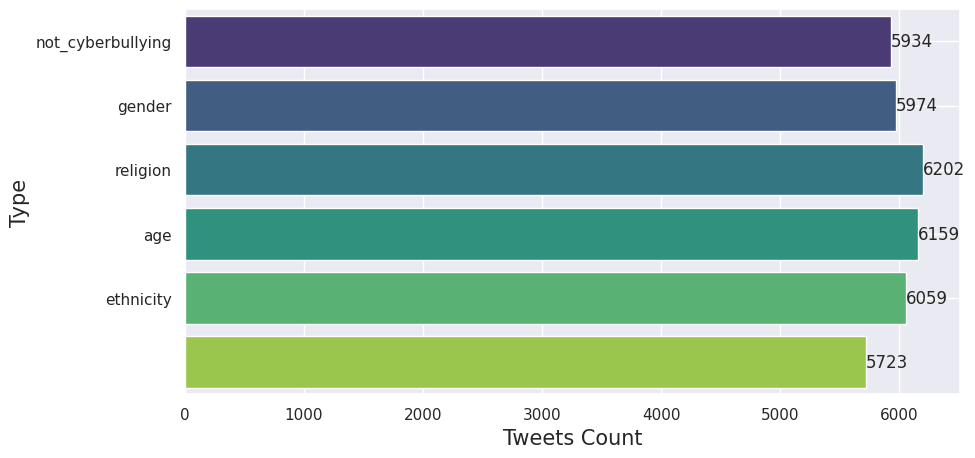

In [37]:
sns.set_theme()
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, y='cyberbullying_type', palette="viridis")
ax.bar_label(ax.containers[0])
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Tweets Count', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

All the classes look balanced.

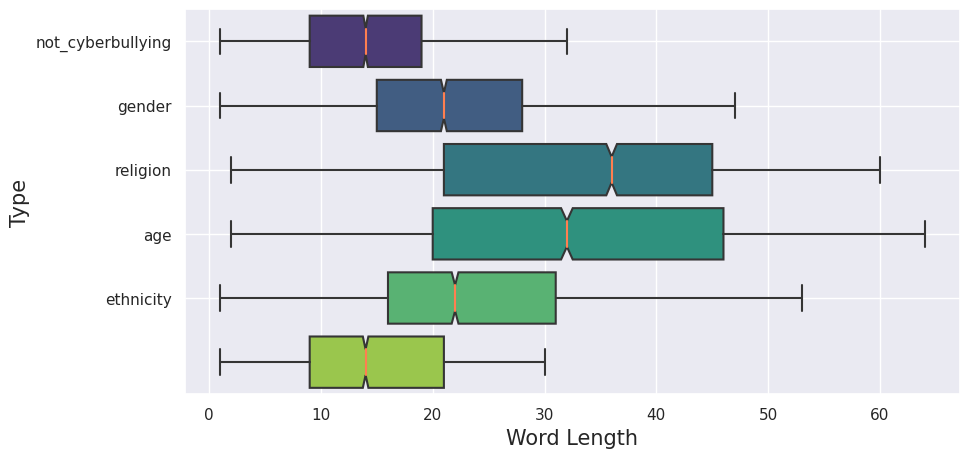

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='cyberbullying_type', x='word_count', orient='h', showfliers=False, palette='viridis', notch=True, medianprops={"color": "coral"})
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Word Length', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

We can observe that the tweets targeted towards a gender tend to have a bit less words in them than say, the ones targeted towards religion.
But overall, a bullying tweet has more words in it and is more varied than a normal one.

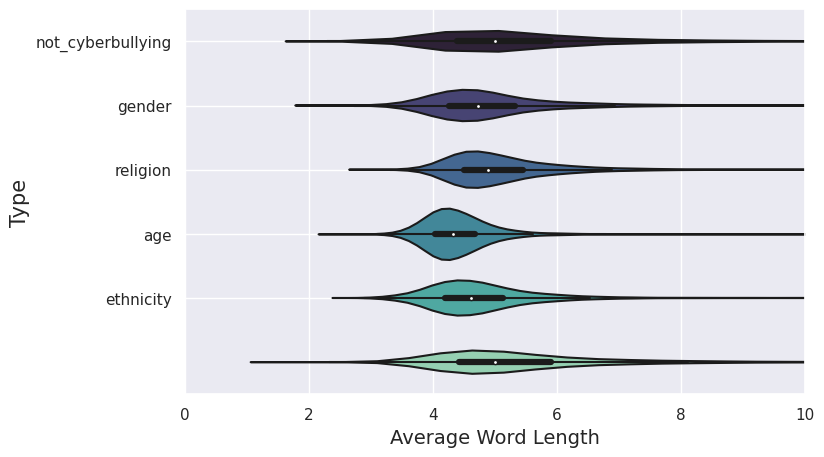

In [41]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, y='cyberbullying_type', x='avg_word_length', orient='h', palette='mako')
plt.xlim(0, 10)
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Average Word Length', size=14)
plt.ylabel('Type', size=15)
plt.grid(color='w')

Pretty much the same for all, between 4 to 6 letters.

Text(32.0, 0.5, 'Average Word Length')

<Figure size 800x500 with 0 Axes>

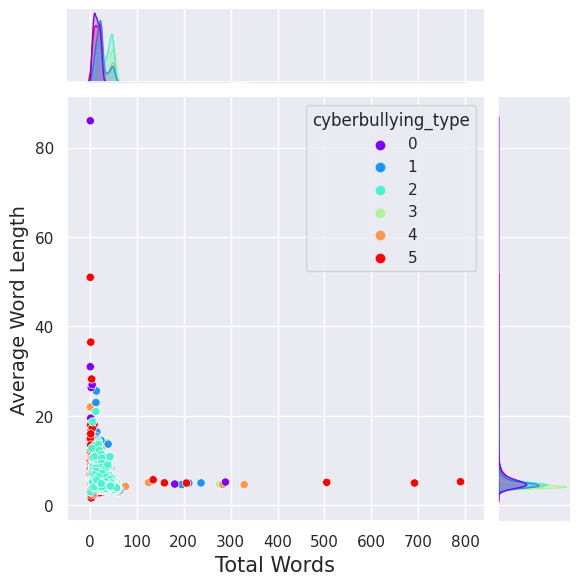

In [42]:
plt.figure(figsize=(8, 5))
sns.jointplot(data=df, y='avg_word_length', x='word_count', hue='cyberbullying_type', palette='rainbow')
plt.xlabel('Total Words', size=15)
plt.ylabel('Average Word Length', size=14)

**Word clouds**

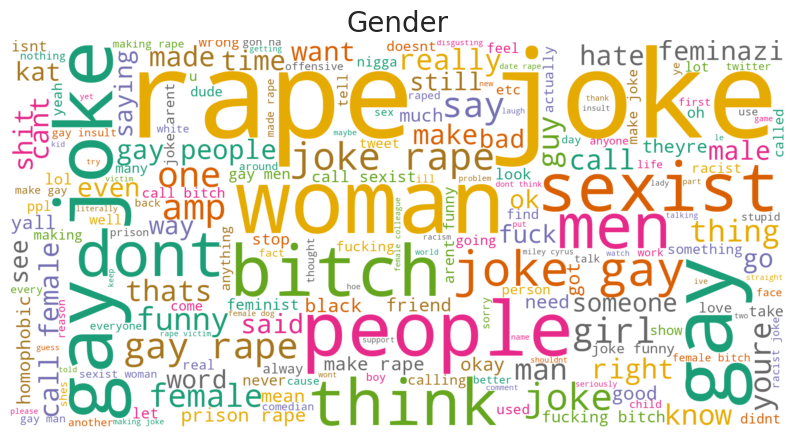

In [43]:
# Gender
plt.figure(figsize=(10, 10))
subset1 = df[df['cyberbullying_type']==1]
text_gender = subset1['clean_tweets'].values
wc1 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_gender))

plt.axis('off')
plt.title("Gender", fontsize=20)
plt.imshow(wc1, interpolation='bilinear')

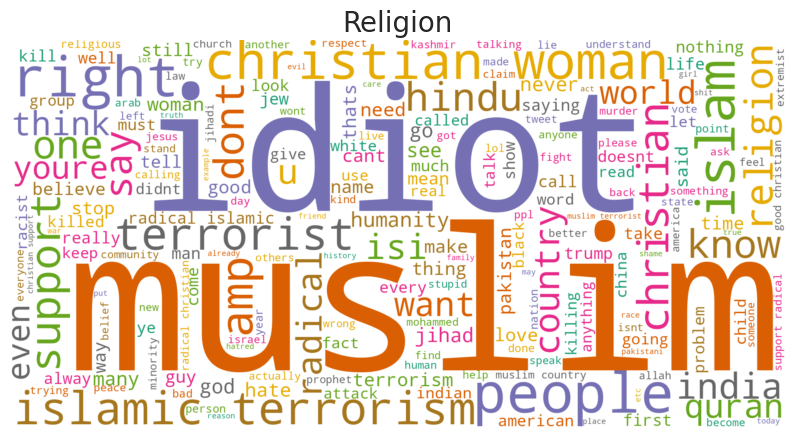

In [44]:
# Religion
plt.figure(figsize=(10, 10))
subset2 = df[df['cyberbullying_type']==2]
text_religion = subset2['clean_tweets'].values
wc2 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_religion))

plt.axis('off')
plt.title("Religion", fontsize=20)
plt.imshow(wc2, interpolation='bilinear')

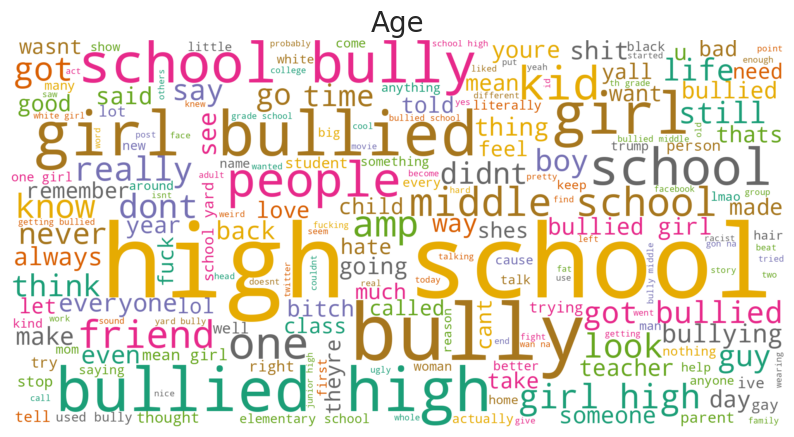

In [45]:
# Age
plt.figure(figsize=(10, 10))
subset3 = df[df['cyberbullying_type']==3]
text_age = subset3['clean_tweets'].values
wc3 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_age))

plt.axis('off')
plt.title("Age", fontsize=20)
plt.imshow(wc3, interpolation='bilinear')

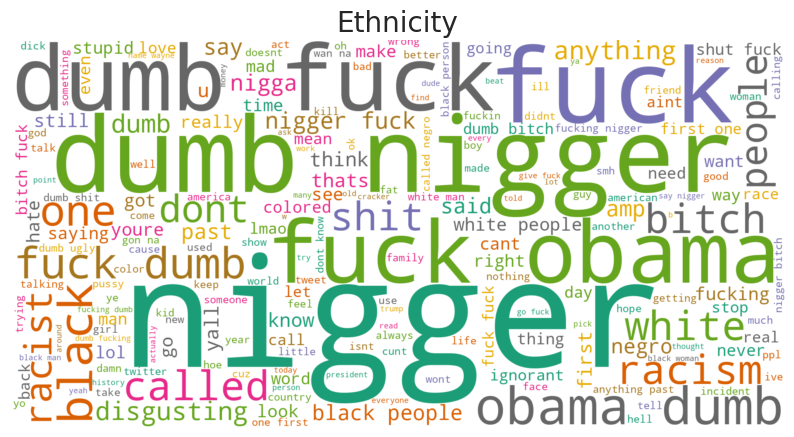

In [46]:
# Ethnicity
plt.figure(figsize=(10, 10))
subset4 = df[df['cyberbullying_type']==4]
text_ethnicity = subset4['clean_tweets'].values
wc4 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity", fontsize=20)
plt.imshow(wc4, interpolation='bilinear')

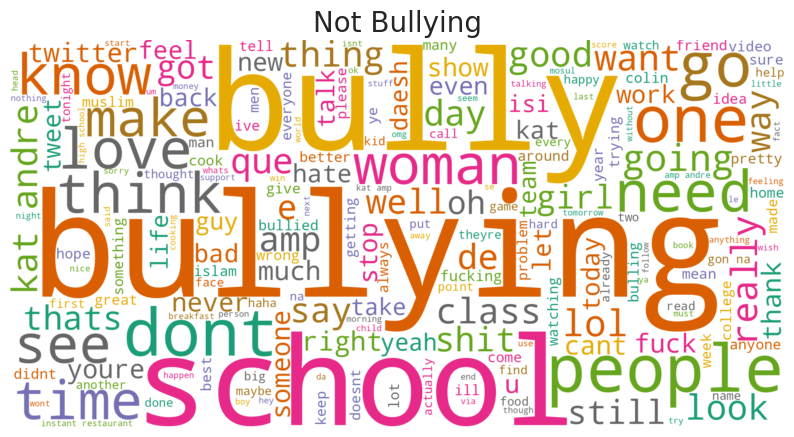

In [47]:
# Not Bullying
plt.figure(figsize=(10, 10))
subset0 = df[df['cyberbullying_type']==0]
text_not = subset0['clean_tweets'].values
wc0 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_not))

plt.axis('off')
plt.title("Not Bullying", fontsize=20)
plt.imshow(wc0, interpolation='bilinear')

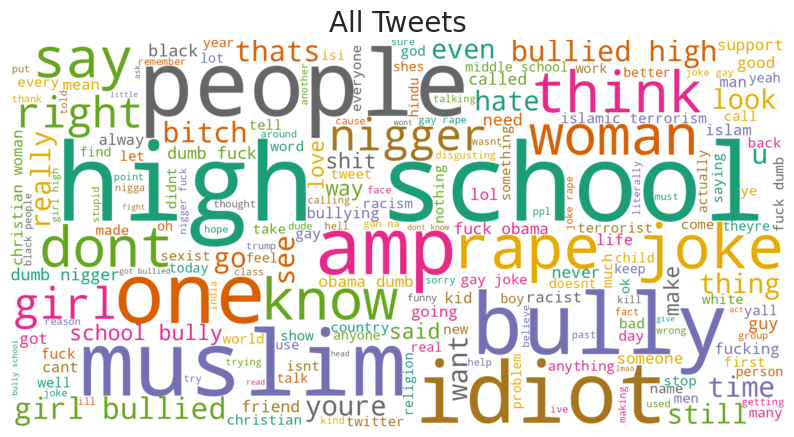

In [51]:
# All Tweets
plt.figure(figsize=(10, 10))
text_all = df['clean_tweets'].values
wc = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_all))

plt.axis('off')
plt.title("All Tweets", fontsize=20)
plt.imshow(wc, interpolation='bilinear')

Now that we're done with the wordclouds, let's check which words are the most popular.

In [52]:
from collections import Counter   # To count the frequency of each word

temp=[]
for tweet in df['clean_tweets']:
  for word in tweet.split():
    temp.append(word)
vocab = Counter(temp)
print("Vocabulary Size:", len(vocab))
print(list(vocab.items())[:5])

Vocabulary Size: 35963
[('every', 722), ('single', 167), ('one', 2856), ('girl', 4287), ('would', 1625)]


**vocab** contains the frequency of all the unique words in the whole dataset. Pretty interesting.
Let's try to plot it and see what we get.

In [53]:
common_word=[]
freq=[]
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)

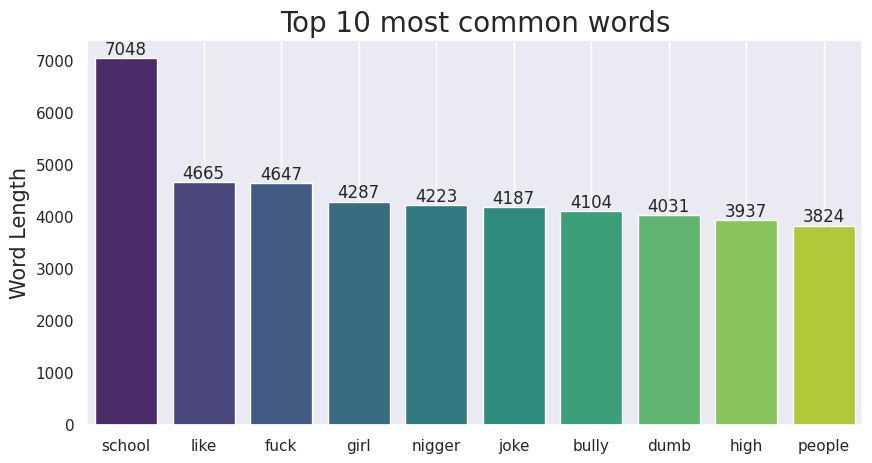

In [54]:
# Most common words
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis')
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()

In [55]:
df

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
0,Every single one is a girl that would have bul...,3,every single one girl would bullied high school,14,4.00
1,that post ab kpop stans going to school togeth...,3,post ab kpop stans going school together every...,30,4.40
2,"Because some people have nothing better to do,...",3,people nothing better bully school never outgrew,20,4.30
3,Bro I coach JV this past year at Skyline....Br...,3,bro coach jv past year skylinebro team could g...,54,4.17
4,These ladies really do remind me of the high s...,3,lady really remind high school chickswith bull...,22,4.86
...,...,...,...,...,...
36046,"@BDSSupporter Who cares where they were born, ...",2,care born camel breath call israeli jew,15,5.67
36047,If being a Muslim didn't stop you from calling...,2,muslim didnt stop calling woke christian shoul...,45,4.53
36048,Oh good. A Christian woman shows up to throw i...,2,oh good christian woman show throw insult righ...,26,4.15
36049,If I really care? You simple in the head? If I...,2,really care simple head really care muslim mai...,44,4.30


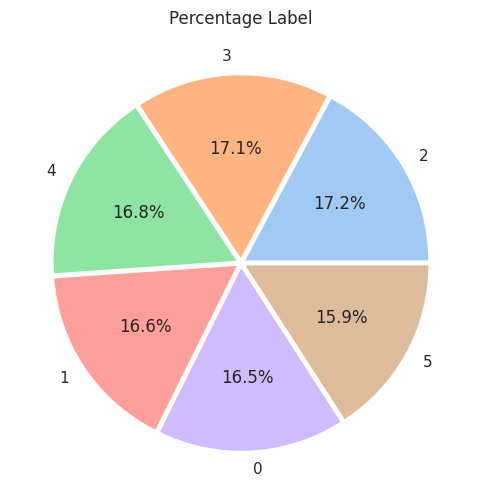

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

label_count = df['cyberbullying_type'].value_counts()

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02] * len(label_count)

plt.figure(figsize=(10, 6))
plt.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
plt.title('Percentage Label')
plt.show()

**Named Entity Recognition (NER) Plot**

In [57]:
import spacy
from spacy import displacy

In [58]:
#sample text
text = df['tweet_text'].iloc[4]

#load pre-trained NER model
nlp = spacy.load('en_core_web_sm')

#perform named entity recognition
doc = nlp(text)

#visualize named entities
displacy.render(doc, style='ent', jupyter=True)

**Part-of-Speech (POS) Tagging Plot**

In [59]:
#sample text
text = df['tweet_text'].iloc[1]

#load pre-trained POS tagging model
nlp = spacy.load('en_core_web_sm')

#perform POS tagging
doc = nlp(text)

#visualize POS tagging
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})